In [1]:
# imports 
import numpy as np
import pandas as pd
import seaborn as sns
import wrangle
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from env import host, user, password
from wrangle import wrangle_zillow 
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LinearRegression, TweedieRegressor
from math import sqrt
from sklearn.preprocessing import RobustScaler

In [2]:
def get_db_url(database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
# prep df
df = wrangle_zillow()
df.head()

,bedroom,bathroom,SqFt,home_value,year_built,tax_amount,pool
0,5.0,4.0,4872.0,970876.0,1991.0,12072.52,1.0
1,3.0,2.0,1812.0,241175.0,1974.0,3110.42,NaN
2,4.0,5.0,4066.0,1236000.0,1992.0,15095.14,1.0
3,4.0,4.0,3083.0,538410.0,1979.0,6700.97,1.0
4,4.0,3.0,2417.0,195224.0,1976.0,2557.31,1.0


In [4]:
# fill nulls in pool column
df['pool'] = df['pool'].fillna(0)

In [ ]:
df.isnull().sum()

In [5]:
df.fillna(0)

,bedroom,bathroom,SqFt,home_value,year_built,tax_amount,pool
0,5.0,4.0,4872.0,970876.0,1991.0,12072.52,1.0
1,3.0,2.0,1812.0,241175.0,1974.0,3110.42,0.0
2,4.0,5.0,4066.0,1236000.0,1992.0,15095.14,1.0
3,4.0,4.0,3083.0,538410.0,1979.0,6700.97,1.0
4,4.0,3.0,2417.0,195224.0,1976.0,2557.31,1.0
...,...,...,...,...,...,...,...
56071,5.0,3.5,3870.0,1025191.0,2005.0,16301.18,0.0
56072,5.0,4.5,3680.0,1204081.0,2004.0,16019.90,0.0
56073,5.0,4.5,4039.0,1707049.0,2005.0,21168.34,0.0
56076,4.0,4.5,3117.0,1689116.0,2004.0,21864.84,0.0


Split data into train, validate and test

In [6]:
seed = 42

train, test_val = train_test_split(df, train_size=0.7,
                                   random_state=seed)

test, valid = train_test_split(test_val, train_size=0.5,
                               random_state=seed)

In [7]:
X_train = train[['pool', 'SqFt', 'bedroom', 'bathroom']]
y_train = train.home_value
X_validate = valid[['pool', 'SqFt', 'bedroom', 'bathroom']]
y_validate = valid.home_value
X_test = test[['pool', 'SqFt', 'bedroom', 'bathroom']]
y_test = test.home_value

In [ ]:
y_validate

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroom", data=train)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom", fontsize=15)
plt.show()


In [ ]:
#Visualize my target 
plt.hist(train.home_value)
plt.xlabel('home value')
plt.ylabel('Frequency')

In [ ]:
exam_corr = train.corr(method='spearman')
exam_corr

In [ ]:
correlation_table = train.corr(method='spearman')
# sns.heatmap(correlation_table, cmap='Blues', annot=True, vmin=0, vmax=1)
sns.heatmap(correlation_table, cmap='Blues', annot=True)

In [9]:
alpha = 0.1
sample = train.bathroom
overall_mean = train.home_value.mean()

t, p = stats.ttest_1samp(sample, overall_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject null")
elif t < 0:
    print("We fail to reject null")
else:
    print("We reject null")


-91094109.41516575 0.0 0.1
We fail to reject null


r = 0.56341
p = 0.0


Text(8, 80, 'r = 0.563')

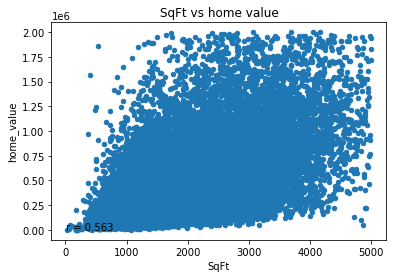

In [8]:
r, p = stats.pearsonr(train.SqFt, train.home_value)
print(f'r = {r:.5f}')
print(f'p = {p:.1f}')


df.plot.scatter('SqFt', 'home_value')
plt.title('SqFt vs home value')
plt.text(8, 80, f'r = {r:.3f}')

Scale data

Text(0.5, 1.0, 'Scaled')

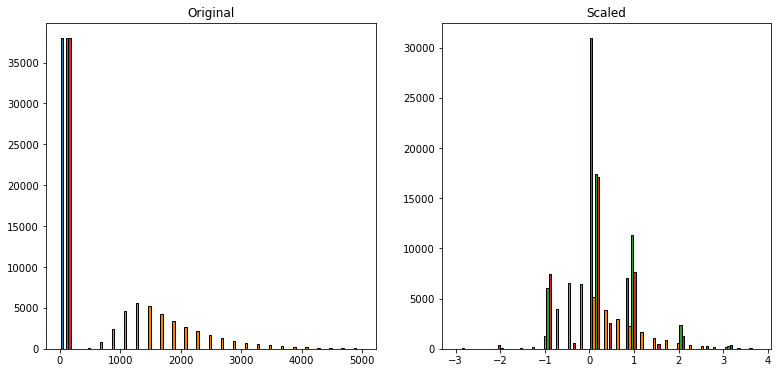

In [11]:

scaler = RobustScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index=X_validate.index, columns=X_validate.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# plot scaled data
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')


In [12]:
kbest = SelectKBest(f_regression, k=2)
kbest.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7fec451af940>)

In [13]:
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train_scaled.columns)
kbest_results

,p,f
pool,0.0,1693.738504
SqFt,0.0,17660.948768
bedroom,0.0,2613.154760
bathroom,0.0,11482.995451


In [14]:
X_train_scaled.columns[kbest.get_support()]

Index(['SqFt', 'bathroom'], dtype='object')

In [15]:
X_train_transformed = pd.DataFrame(
    kbest.transform(X_train),
    index=X_train_scaled.index,
    columns=X_train_scaled.columns[kbest.get_support()]
)
X_train_transformed.head()

,SqFt,bathroom
14064,1120.0,1.0
29556,1869.0,3.0
23797,720.0,1.0
10575,1243.0,2.0
25618,1804.0,3.0


predictions DF

In [20]:
predictions = pd.DataFrame({
    'actual': train.home_value
})

In [19]:
predictions['baseline'] = train.home_value.mean()

NameError: name 'predictions' is not defined

In [ ]:
predictions.head()

Linear Regression

In [16]:
## fit model on x train
lm = LinearRegression().fit(X_train_transformed,
                            y_train)

In [17]:
lm_predict = lm.predict(X_train_transformed)
lm_predict

array([223144.5868305 , 432579.5614202 , 139701.09999215, ...,
       283741.33045957, 682593.02017233, 520195.22260047])

In [18]:
predictions['lm'] = lm.predict(X_train_transformed)
predictions.head()

NameError: name 'predictions' is not defined

In [21]:
yhat = lm.predict(X_train_transformed)
yhat

array([223144.5868305 , 432579.5614202 , 139701.09999215, ...,
       283741.33045957, 682593.02017233, 520195.22260047])

In [22]:
predictions['yhat'] = yhat
predictions.head()

,actual,yhat
14064,320819.0,223144.586831
29556,876160.0,432579.561420
23797,94339.0,139701.099992
10575,58141.0,275396.981776
25618,776649.0,419019.994809


Model

Lasso Lars

In [23]:
lars = LassoLars(alpha=1.0)

lars.fit(X_train_transformed, y_train)

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


LassoLars()

In [24]:
lars_predict = lars.predict(X_train_transformed)

In [25]:
predictions['lars'] = lars.predict(X_train_transformed)
predictions.head()

,actual,yhat,lars
14064,320819.0,223144.586831,223390.822978
29556,876160.0,432579.561420,432457.179714
23797,94339.0,139701.099992,140006.487467
10575,58141.0,275396.981776,275496.100393
25618,776649.0,419019.994809,418907.225193


GLM

In [26]:
glm = TweedieRegressor(power=0, alpha=1)

glm.fit(X_train_transformed, y_train)

TweedieRegressor(alpha=1, power=0)

In [27]:
glm_predict = glm.predict(X_train_transformed)

In [28]:
predictions['glm'] = glm.predict(X_train_transformed)
predictions.head()

,actual,yhat,lars,glm
14064,320819.0,223144.586831,223390.822978,235017.885992
29556,876160.0,432579.561420,432457.179714,416475.520426
23797,94339.0,139701.099992,140006.487467,143597.277332
10575,58141.0,275396.981776,275496.100393,268265.995514
25618,776649.0,419019.994809,418907.225193,401619.671518


In [29]:
mean_squared_error(y_train, glm_predict)

61974200849.66952

In [30]:
mean_squared_error(y_train, lars_predict)

61864037082.23817

In [31]:
# best preforming model
mean_squared_error(y_train, lm_predict)

61863995125.4222

In [ ]:
predictions['residuals'] = predictions['yhat'] - train['home_value']
predictions.head()

transform Validate

In [32]:
# tranform x validate 
X_validate_transformed = pd.DataFrame(
    kbest.transform(X_validate_scaled),
    index=X_validate_scaled.index,
    columns=X_validate_scaled.columns[kbest.get_support()]
)
X_validate_transformed.head()

,SqFt,bathroom
2971,0.633509,1.0
34126,2.028341,1.5
11883,-0.467908,0.0
46033,1.658238,2.0
53562,0.296749,1.0


In [36]:
# transform y validate 
y_validate_transformed = pd.DataFrame(
    kbest.transform(y_validate2),
    index=y_validate2.index,
    columns=y_validate2.columns[kbest.get_support()]
)
y_validate_transformed.head()

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- home_value
Feature names seen at fit time, yet now missing:
- SqFt
- bathroom
- bedroom
- pool

  warnings.warn(message, FutureWarning)


ValueError: X has 1 features, but SelectKBest is expecting 4 features as input.

In [34]:
# turn y validate into df
y_validate2 = pd.DataFrame(y_validate)

In [35]:
y_validate2

,home_value
2971,128060.0
34126,556036.0
11883,261570.0
46033,512578.0
53562,258882.0
...,...
34998,252581.0
7142,218220.0
48107,239887.0
23762,233223.0


In [ ]:
# predict validate
lm_Val = lm.predict(X_validate_transformed)
lm_Val

In [ ]:
lars_Val = lars.predict(X_validate_transformed)
lars_Val

In [ ]:
glm_Val = glm.predict(X_validate_transformed)

Evaluate RMSE

rmse_validate = mean_squared_error(y_validate, y_validate)**(1/2)